# Multiclass Text classification  [link1](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) [link2](https://www.tensorflow.org/tutorials/keras/text_classification)
# matplotlib quick referance [link](https://matplotlib.org/stable/tutorials/introductory/quick_start.html)

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np


from tensorflow.keras import layers
from tensorflow.keras import losses
# tf.debugging.set_log_device_placement(True) # to see which operation usees GPU
print('gpu', 'available' if tf.config.list_physical_devices('GPU') else  'not available')

2023-02-21 00:48:03.607019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 00:48:04.552583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-21 00:48:04.552833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-21 00:48:04.552850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

gpu available


2023-02-21 00:48:06.228237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 00:48:06.239236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 00:48:06.239695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Downlaoding the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

os.chdir('3-text-classifcation-dataset')
dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [3]:
# spliting train and test
BATCH_SIZE = 256
SEED = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='training', 
    seed=SEED)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='validation', 
    seed=SEED)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=BATCH_SIZE)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2023-02-21 00:48:13.145771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 00:48:13.146452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 00:48:13.146907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 00:48:13.147278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. Use a pre-trained text embedding as the first layer, which will have three advantages:

*   You don't have to worry about text preprocessing,
*   Benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example you use a **pre-trained text embedding model** from [TensorFlow Hub](https://tfhub.dev) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are many other pre-trained text embeddings from TFHub that can be used in this tutorial:

* [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2) - trained with the same NNLM architecture on the same data as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - the same as [google/nnlm-en-dim128/2](https://tfhub.dev/google/nnlm-en-dim128/2), but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
* [google/universal-sentence-encoder/4](https://tfhub.dev/google/universal-sentence-encoder/4) - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

And many more! Find more [text embedding models](https://tfhub.dev/s?module-type=text-embedding) on TFHub

In [4]:
# Adding pretrained Embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)



In [5]:
train_examples_batch, train_label_batch = next(iter(raw_train_ds.batch(1)))
train_examples_batch.shape
hub_layer(tf.reshape(train_examples_batch, [-1])[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.7757115 , -0.2566283 , -0.14953938,  0.33913833, -0.08331208,
        -0.28537047, -0.00722903,  0.4464495 , -0.5067184 ,  0.37666485,
        -0.11104527,  0.31945726,  0.04401777, -0.05765314, -0.03428812,
         0.34541658,  0.11156015,  0.19140567,  0.34009796, -0.11520258,
        -0.15712707,  0.20059572,  0.6525242 ,  0.16449147, -0.35179675,
        -0.1556478 , -0.60899156,  0.31617853,  0.02223825, -0.24408376,
        -0.26769632,  0.560487  ,  0.34614047, -0.23421213, -0.06173125,
        -0.42689708,  0.02657206, -0.24979965,  0.11020792,  0.2719436 ,
        -0.01676132,  0.27268663, -0.24462897,  0.16690584, -0.13979574,
         0.01056808, -0.45195085, -0.09379447,  0.11692032,  0.39268494]],
      dtype=float32)>

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE


raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# The model


model = tf.keras.Sequential([
    hub_layer, # pretrained on https://tfhub.dev/google/nnlm-en-dim50/2
    layers.Dense(16, activation='elu'),
    # layers.Dropout(0.2), 
    layers.Dense(4) # 4 classes
    
])
#you can also use model.add(hub_layer)
#                 model.add(layers.Dense(16) .........

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(
    optimizer='adam',
    metrics=['accuracy'],
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True) # sparse means the classes not vecotrs
    # i.e [0, 0, 1, 0] insted they a number i.e: 2
)

In [14]:
# Training
EPOCHS = 10
# BATCH_SIZE = 128
history = model.fit(raw_train_ds.shuffle(10000),
                   validation_data = raw_val_ds,
                   epochs = EPOCHS,
                   verbose=1)

Epoch 1/10
25/25 [==============================] - 5s 167ms/step - loss: 1.3310 - accuracy: 0.3902 - val_loss: 1.1911 - val_accuracy: 0.5450
Epoch 2/10
25/25 [==============================] - 1s 33ms/step - loss: 1.0151 - accuracy: 0.7058 - val_loss: 0.9996 - val_accuracy: 0.6825
Epoch 3/10
25/25 [==============================] - 1s 33ms/step - loss: 0.7975 - accuracy: 0.8195 - val_loss: 0.8609 - val_accuracy: 0.7250
Epoch 4/10
25/25 [==============================] - 1s 33ms/step - loss: 0.6280 - accuracy: 0.8659 - val_loss: 0.7571 - val_accuracy: 0.7456
Epoch 5/10
25/25 [==============================] - 1s 34ms/step - loss: 0.5000 - accuracy: 0.8908 - val_loss: 0.6900 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 1s 34ms/step - loss: 0.4019 - accuracy: 0.9133 - val_loss: 0.6444 - val_accuracy: 0.7588
Epoch 7/10
25/25 [==============================] - 1s 33ms/step - loss: 0.3300 - accuracy: 0.9303 - val_loss: 0.6175 - val_accuracy: 0.7606
Epoch 8/10
2

In [15]:
# evaluating the model
loss, accuracy = model.evaluate(raw_test_ds, verbose=2)

32/32 - 0s - loss: 0.6461 - accuracy: 0.7508 - 270ms/epoch - 8ms/step


In [16]:
print(history.history.keys())
print(len(history.history['val_accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10


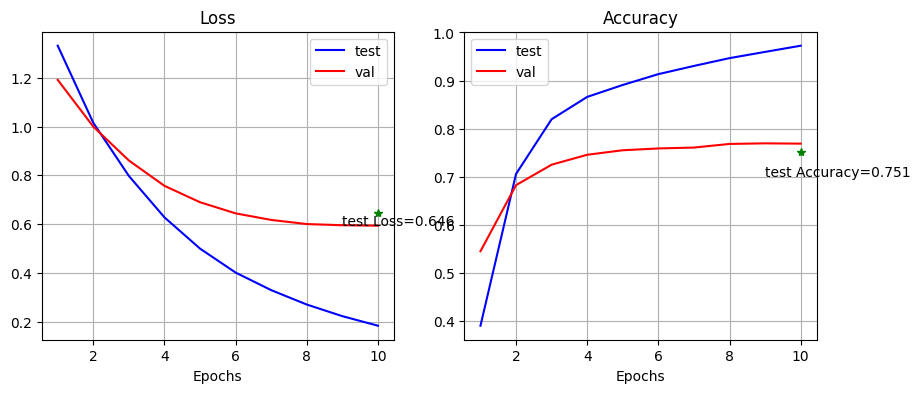

In [17]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    ax.annotate(f"test {title}={test_point:.3f}", xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_test_val(ax1, 'Loss', history.history['loss'], history.history['val_loss'], loss)
plot_test_val(ax2, 'Accuracy', history.history['accuracy'], history.history['val_accuracy'], accuracy)

plt.show()


In [18]:
# making model ready for production
prediction_model = tf.keras.Sequential([
    model, 
    layers.Softmax()
])

prediction_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4)                 48191484  
                                                                 
 softmax (Softmax)           (None, 4)                 0         
                                                                 
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


In [20]:
test_data = [
    "maxdegreeofparallelism not limiting the number of parallel tasks i am creating a number of threads and want to execute only n at a time. but i have a problem that when the code is executed it starts all threads at once...for (int i = 0; i &lt; global.mylist.count - 1; i++).{.    thread thread = new thread(() =&gt;.    {.        debug.writeline(""start signal from thread"", thread.currentthread.name);.        var account = global.mylist[i];.        thread.sleep(5000);.        debug.writeline(""end signal from thread"", thread.currentthread.name);.    });.    thread.name = i.tostring();.    threads.add(thread);.}..var option = new paralleloptions().{.    maxdegreeofparallelism = convert.toint32(numthreads.value).};..var locker = new object();.parallel.foreach(threads, option, t =&gt;.{.    if (t.isalive == false).    {.        t.start();.    }.    var count = convert.toint32(t.name);.    interlocked.increment(ref count);.    lock (locker).    {.        debug.writeline(""number of active threads:"" + count);.        thread.sleep(10);.    }.    interlocked.decrement(ref count);.});"
,
    
]
print(prediction_model.predict(test_data))
print(raw_train_ds.class_names)

1/1 [==============================] - 0s 161ms/step
[[0.81481    0.11202502 0.06815131 0.00501364]]


AttributeError: 'PrefetchDataset' object has no attribute 'class_names'